In [67]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers


In [69]:
df = pd.read_csv('/Users/kim-yongjun/Documents/부스트캠프 AI Tech 7기/5.5. NLP 기초 프로젝트/nlp_project/train.csv')
tokenizer = transformers.AutoTokenizer.from_pretrained('klue/bert-base')

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

/opt/homebrew/anaconda3/envs/yongari/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

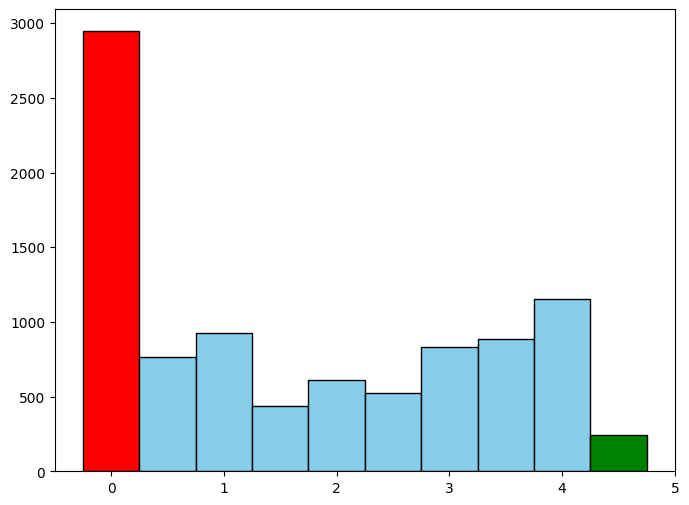

In [61]:
cnt, bins = np.histogram(df['label'], bins = 10)
max_bin_index = np.argmax(cnt)
min_bin_index = np.argmin(cnt)
colors = ['skyblue' for _ in range(10)]
colors[max_bin_index] = 'red'
colors[min_bin_index] = 'green'
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.bar(bins[i], cnt[i], width=(bins[1] - bins[0]), color=colors[i], edgecolor='black')


## 단어의 라벨 분포를 살펴보니, label = 0인 데이터가 상당히 많음을 알 수 있다.
## 모델이 잘 학습하기 위해서는 label의 편향이 적을수록 좋으므로 나중에 label의 분포를 고루 퍼지도록 해야한다

In [152]:
person = df[df['sentence_1'].str.contains('<PERSON>')|df['sentence_2'].str.contains('<PERSON>')]
person[['sentence_1', 'sentence_2']]
print('발견된 <PERSON> 횟수 :', len(person))
print(round(len(person) / len(df) * 100, 4, ), '% 의 데이터에 <PERSON> 이 존재합니다.')
ids = tokenizer('<PERSON>')['input_ids']
for id in ids:
    print(tokenizer.decode(id), end = ' ')

발견된 <PERSON> 횟수 : 138
1.4801 % 의 데이터에 <PERSON> 이 존재합니다.
[CLS] < PER ##S ##ON > [SEP] 

## 데이터를 살펴보니, sentence_1, sentence_2 컬럼의 문장들에 'PERSON'이라는 단어가 꽤 많이 등장함을 알 수 있었다.
## 모델은 Bert-base기준 <PERSON>이라는 단어는 하나의 토큰으로 분류돼 있지 않다.
## 이는 모델의 학습에 악영향을 끼칠 수 있음으로 추후 조치가 필요하다.

In [114]:
import re
def has_repeated_words(sentence):
    # 정규 표현식: 같은 단어가 3번 이상 연속으로 나오는지 확인
    pattern = r'\b(\w+)\b\s+\1\s+\1'
    b1 = bool(re.search(pattern, sentence))
    pattern = r'(\w+)\1\1'
    b2 = bool(re.search(pattern, sentence))
    if b1 or b2 and not re.search(r'(ㅋㅋㅋ|ㅎㅎㅎ)', sentence):
        return True
    else:
        return False
    

repeated_df = df[df['sentence_1'].apply(has_repeated_words) | df['sentence_2'].apply(has_repeated_words)]
print('같은 단어가 반복되는 문장 수 :', len(repeated_df))
repeated_df[['sentence_1','sentence_2']].sample(20)

같은 단어가 반복되는 문장 수 : 124


,sentence_1,sentence_2
4576,"평창 올림픽 오뎅호떡 가격 논란,호떡 2개 5000원","이상호 2억원, 여자컬링 0원…경기단체 포상금 '천차만별' 이게 현실인가요?"
7855,오마이!! 너무너무 축하드려요!!!,세상에!! 으어어어 세상에.. 너무너무 축하드려요!!!!
7182,ㅋㅋㅋ적당해보여욥!,하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하하
2619,재미없진않네요 하하하,너무 재미없었어요^-^
2598,오 영광의 소환…!,오마이! 어떠셨나요ㅠㅠㅠ
5738,푸하하하~ 코미디라는 장르에 아주 충실하군..,장르 코미디 아닌건 확실하다..
6149,연봉상위 1% 고고고!,우리 회사 고고고!
4528,나만 낚일 순 없지,나만당할순없지 낄낄낄
9011,어머머머 신기하고 웃기기도하고 그러는데…,늘 궁금하고 신기해 했던 ㅋㅋ
4394,너와나함께라면 우린 최고야,최고 최고 최고 최고 최고다 그냥


## 정규식을 통해 같은 글자가 세 번 이상 반복되는 문장들이 124개 가량 존재했음을 발견하였다. (ㅋㅋㅋ, ㅎㅎㅎ 는 제외)

## 이는 마찬가지로 모델의 학습에 불필요한 요소이므로 3번 이상 반복되는 단어들의 처리가 필요함을 알 수 있다.

In [142]:
cnt1, bins = np.histogram(df['sentence_1'].apply(lambda x: len(max(x.split()))), bins = 20)
cnt2, bins = np.histogram(df['sentence_2'].apply(lambda x: len(max(x.split()))), bins = 20)
cnt = cnt1 + cnt2

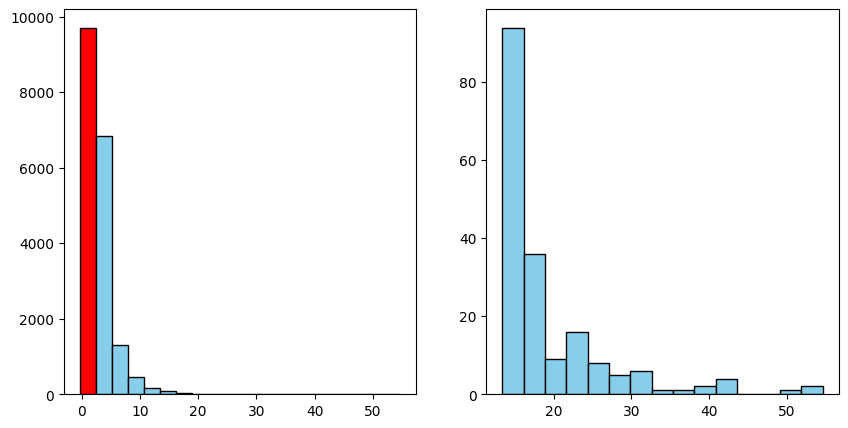

In [232]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
max_bin_index = np.argmax(cnt)
min_bin_index = np.argmin(cnt)
colors = ['skyblue' for _ in range(20)]
colors[max_bin_index] = 'red'
colors[min_bin_index] = 'green'
for i in range(20):
    axes[0].bar(bins[i], cnt[i], width = (bins[1] - bins[0]), color=colors[i], edgecolor='black')
for i in range(5,20,1):
    axes[1].bar(bins[i], cnt[i], width = (bins[1] - bins[0]), color=colors[i], edgecolor = 'black')


## 문장의 단어들을 띄어쓰기 기준으로 분리한 후 가장 긴 단어를 봤을 때, 대부분의 단어는 정상적으로 1~7정도의 단어 길이를 가지고 있었지만,
## 몇몇의 단어들의 길이가 10 이상인 것을 발견하였다.
## 이는 띄어쓰기가 제대로 이루어지지 않은 단어가 존재함을 암시한다.

In [231]:
from collections import defaultdict
def find_unk_words(sentence):
    unk_list = []
    sentences = sentence.split()
    for word in sentences:
        if tokenizer.encode(word)[1] == tokenizer.unk_token_id:
            unk_list.append(word)
    return unk_list
unk_in_sentence_1 = df['sentence_1'].apply(find_unk_words)
unk_in_sentence_2 = df['sentence_2'].apply(find_unk_words)
unk_in_sentence_1 = unk_in_sentence_1.value_counts()[1:]
unk_in_sentence_2 = unk_in_sentence_2.value_counts()[1:]
sentence_1_tokens_len = df['sentence_1'].apply(lambda x:len(tokenizer(x)['input_ids'])).sum()
sentence_2_tokens_len = df['sentence_2'].apply(lambda x:len(tokenizer(x)['input_ids'])).sum()
all_tokens_len = sentence_1_tokens_len + sentence_2_tokens_len
d = defaultdict(int)
for sentence in unk_in_sentence_1.index:
    for word in sentence:
        d[word] += 1
for sentence in unk_in_sentence_2.index:
    for word in sentence:
        d[word] += 1

d = dict(sorted(d.items(), key = lambda x:x[1],reverse = True))
print('다양한 [UNK] 토큰들 :',list(d)[:12])
print('[UNK] 토큰의 개수 ;', sum(d.values()))
print('전체 토큰들 중 [UNK] 토큰의 비율:', 100 * sum(d.values()) / (all_tokens_len - sum(d.values())), '%')

다양한 [UNK] 토큰들 : ['넵', '뵐', '넵.', '앜ㅋㅋ', '쑈!', '뵌', '봣는데', '시킵시다.', '왤케', '네넵!', '넵!', '넵넵!!']
[UNK] 토큰의 개수 ; 429
전체 토큰들 중 [UNK] 토큰의 비율: 0.15460128005535376 %


## 모든 문장에서 Tokenizer가 [UNK] 토큰으로 받아들인 단어들을 빈도수로 내림차순 정렬 한 뒤 12개만 본 결과이다.
## Tokenizer가 잡지 못하는 단어들은 주로 넵, 넵! 등의 단어였으며, 문재인 > 문제인 등의 오타도 포함돼 있었다.

## 정리해보면, 본 데이터는
### 1. Label의 균형을 맞춰야 함.
### 2. 자주 등장하는 'PERSON' 단어를 Tokenizer마다 다르게 해석할 수 있으므로 하나의 Special Token으로 추가해야 함.
### 3. 같은 단어들이 반복되는 문장들을 교정해야 함.
### 4. 띄어쓰기 교정을 통해 올바른 문장으로 바꿔야 함.
### 5. 오타로 인한 [UNK] Token 생성을 줄여야 함.
### 의 처리들이 필요함을 알 수 있다.